In [1]:
import sys
import numpy as np
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/')
from chiphifunc import *
from math_utilities import *
from chiphiepsfunc import *
from chiphifunc_test_suite import *
import time

# for debugging
import scipy.interpolate

Detected 16 CPU's. Setting n_jobs to #CPU/2.


## Testing display_content()


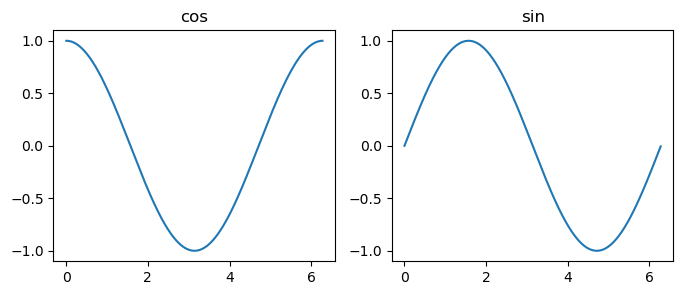

In [3]:
content1 = np.array([
    np.sin(points), # sin component
    np.cos(points) # cos component
])

ChiPhiFuncGrid(content1, fourier_mode = True).display_content()

## Defining test variables

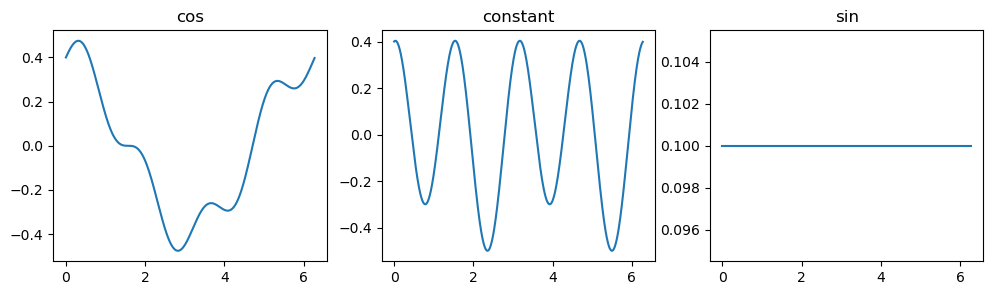

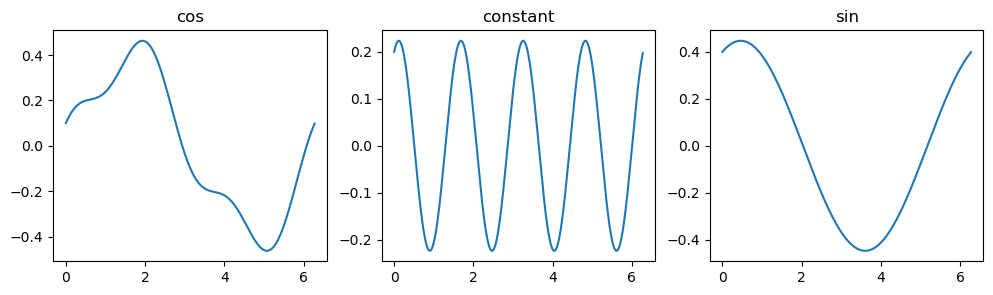

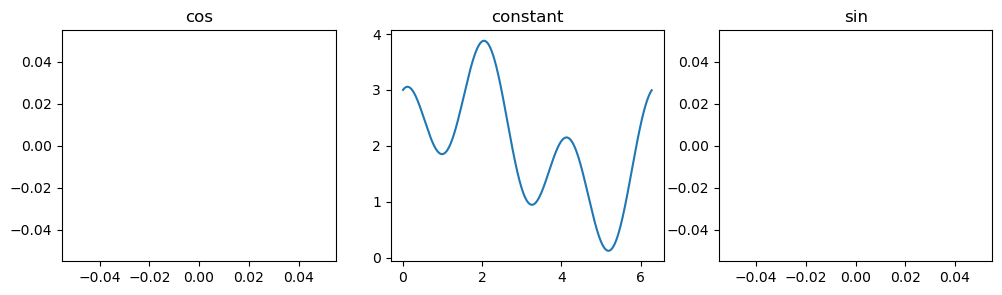

In [3]:
# Generating 2 random test cases and answers

# Creating 2 random ChiPhiFuncGrid's for testing
rands1 = np.random.randint(5, size=12)
func1 = np.vectorize(lambda chi, phi : \
    (rands1[0]/10*np.sin(rands1[1]*phi) + rands1[2]/10*np.cos(rands1[3]*phi))*np.sin(2*chi)+\
    rands1[4]/10*np.sin(rands1[5]*phi) + rands1[6]/10*np.cos(rands1[7]*phi)+\
    (rands1[8]/10*np.sin(rands1[9]*phi) + rands1[10]/10*np.cos(rands1[11]*phi))*np.cos(2*chi))

content1 = np.array([
    rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points)
])


rands2 = np.random.randint(5, size=12)
func2 = np.vectorize(lambda chi, phi : \
    (rands2[0]/10*np.sin(rands2[1]*phi) + rands2[2]/10*np.cos(rands2[3]*phi))*np.sin(2*chi)+\
    rands2[4]/10*np.sin(rands2[5]*phi) + rands2[6]/10*np.cos(rands2[7]*phi)+\
    (rands2[8]/10*np.sin(rands2[9]*phi) + rands2[10]/10*np.cos(rands2[11]*phi))*np.cos(2*chi))
content2 = np.array([
    rands2[0]/10*np.sin(rands2[1]*points) + rands2[2]/10*np.cos(rands2[3]*points),
    rands2[4]/10*np.sin(rands2[5]*points) + rands2[6]/10*np.cos(rands2[7]*points),
    rands2[8]/10*np.sin(rands2[9]*points) + rands2[10]/10*np.cos(rands2[11]*points)
])

randsodd = np.random.randint(5, size=16)
funcodd = np.vectorize(lambda chi, phi : \
    (randsodd[0]/10*np.sin(randsodd[1]*phi) + randsodd[2]/10*np.cos(randsodd[3]*phi))*np.sin(3*chi)+\
    (randsodd[4]/10*np.sin(randsodd[5]*phi) + randsodd[6]/10*np.cos(randsodd[7]*phi))*np.sin(1*chi)+\
    (randsodd[8]/10*np.sin(randsodd[9]*phi) + randsodd[10]/10*np.cos(randsodd[11]*phi))*np.cos(1*chi)+\
    (randsodd[12]/10*np.sin(randsodd[13]*phi) + randsodd[14]/10*np.cos(randsodd[15]*phi))*np.cos(3*chi))
contentodd = np.array([
    randsodd[0]/10*np.sin(randsodd[1]*points) + randsodd[2]/10*np.cos(randsodd[3]*points),
    randsodd[4]/10*np.sin(randsodd[5]*points) + randsodd[6]/10*np.cos(randsodd[7]*points),
    randsodd[8]/10*np.sin(randsodd[9]*points) + randsodd[10]/10*np.cos(randsodd[11]*points),
    randsodd[12]/10*np.sin(randsodd[13]*points) + randsodd[14]/10*np.cos(randsodd[15]*points)
])


rands3 = np.random.randint(low=1, high=5, size=2)
func_no_chi = np.vectorize(lambda chi, phi : 
    np.sin(rands3[0]*phi) + np.cos(rands3[1]*phi)+2)
content_no_chi = np.array([
    np.sin(rands3[0]*points) + np.cos(rands3[1]*points) + 2
])
test1 = ChiPhiFuncGrid(content1, fourier_mode = True)
test2 = ChiPhiFuncGrid(content2, fourier_mode = True)
testodd = ChiPhiFuncGrid(contentodd, fourier_mode = True)
test_no_chi = ChiPhiFuncGrid(content_no_chi, fourier_mode = True)

# plt.pcolormesh(chi, phi, func1_result)
# plt.show()
test1.display_content()
test2.display_content()
test_no_chi.display_content()




In [4]:

funcodd_result = evaluate(funcodd)
func1_result = evaluate(func1)
func2_result = evaluate(func2)
func_no_chi_result = evaluate(func_no_chi)

## Testing basic operations

In [5]:
print('Testing lambda:')
print_fractional_error(evaluate_ChiPhiFunc(testodd), (funcodd_result))

Testing lambda:
Error type:     Fractional      Total          
Avg:            3.357e-07       1.346e-17      
Worst:          1.002e-01       2.225e-16      
Std             1.71e-04        2.246e-17      
Total imaginary component
0.0



In [6]:
print('Testing +:')
print('Odd-odd:')
print_fractional_error(evaluate_ChiPhiFunc(testodd+testodd), (funcodd_result+funcodd_result))
print('Even-even:')
print_fractional_error(evaluate_ChiPhiFunc(test1+test2+1), (func1_result+func2_result+1))

print('Testing -:')
print_fractional_error(evaluate_ChiPhiFunc(test1-test2-test_no_chi), (func1_result-func2_result-func_no_chi_result))

print('Testing *:')
print('Odd-odd:')
print_fractional_error(evaluate_ChiPhiFunc(testodd*testodd), (funcodd_result*funcodd_result))
print('Even-even:')
print_fractional_error(evaluate_ChiPhiFunc(test1*test2), (func1_result*func2_result))
print('Even-odd:')
print_fractional_error(evaluate_ChiPhiFunc(test1*testodd), (func1_result*funcodd_result))

print('Testing /:')
print('Even:')
print_fractional_error(evaluate_ChiPhiFunc(test1/test_no_chi), (func1_result/func_no_chi_result))
print('Odd:')
print_fractional_error(evaluate_ChiPhiFunc(testodd/test_no_chi), (funcodd_result/func_no_chi_result))


print('Testing **:')
print_fractional_error(evaluate_ChiPhiFunc(test1**3), (func1_result*func1_result*func1_result))
print_fractional_error(evaluate_ChiPhiFunc(testodd**3), (funcodd_result*funcodd_result*funcodd_result))


Testing +:
Odd-odd:
Error type:     Fractional      Total          
Avg:            3.357e-07       2.692e-17      
Worst:          1.002e-01       4.45e-16       
Std             1.71e-04        4.492e-17      
Total imaginary component
0.0

Even-even:
Error type:     Fractional      Total          
Avg:            8.205e-17       8.436e-17      
Worst:          1.203e-15       4.441e-16      
Std             1.014e-16       1.062e-16      
Total imaginary component
0.0

Testing -:
Error type:     Fractional      Total          
Avg:            9.994e-17       1.515e-16      
Worst:          7.976e-13       8.882e-16      
Std             2.303e-15       1.951e-16      
Total imaginary component
0.0

Testing *:
Odd-odd:
Error type:     Fractional      Total          
Avg:            1.898e+09       3.026e-17      
Worst:          4.741e+14       5.835e-16      
Std             7.287e+11       4.218e-17      
Total imaginary component
0.0

Even-even:
Error type:     Fractional      Tot

## Basic operations, cumulative Error

In [7]:
print('Testing +:')
add_test = lambda a : a+test1
add_ans = lambda a : a+func1_result
cumulative_error(test1, func1_result, add_test, add_ans, 30)

Testing +:


TypeError: cumulative_error() takes 4 positional arguments but 5 were given

In [ ]:
print('Testing *:')
mul_test = lambda a : a*test2
mul_ans = lambda a : a*func2_result
cumulative_error(test1, func1_result, mul_test, mul_ans, 30)

In [ ]:


print('Testing py_sum:')
def sum_arg(i):
    return(test1*i**2)
    
print_fractional_error(evaluate_ChiPhiFunc(py_sum(sum_arg,2,50)), evaluate_ChiPhiFunc(test1*42924))

In [ ]:
print('Testing +0, 0+:')
print_fractional_error(evaluate_ChiPhiFunc(test1+0), evaluate_ChiPhiFunc(test1))
print_fractional_error(evaluate_ChiPhiFunc(0+test1), evaluate_ChiPhiFunc(test1))

print('Testing -0, 0-:')
print_fractional_error(evaluate_ChiPhiFunc(test1-0), evaluate_ChiPhiFunc(test1))
print_fractional_error(evaluate_ChiPhiFunc(0-test1), evaluate_ChiPhiFunc(-test1))

print('Testing *0, 0*:')
print_fractional_error((test1*0), 0)
print_fractional_error((0*test2*test_no_chi*1.2356), 0)

print('Testing **0:')
print_fractional_error(test1**0, 1)


In [ ]:
all_0_test = ChiPhiFuncGrid(np.array([[0,0],[0,0]]))
print('Testing null')
print('const * null:')
print(5*ChiPhiFuncNull())
print(ChiPhiFuncNull()*5)
print('test1 * null:')
print(test1*ChiPhiFuncNull())
print(ChiPhiFuncNull()*test1)
print('0 * null:')
print(0*ChiPhiFuncNull())
print(ChiPhiFuncNull()*0)
print('0 ChiPhiFuncGrid * null:')
print(all_0_test*ChiPhiFuncNull())
print(ChiPhiFuncNull()*all_0_test)



## Testing differential and integral

Testing dchi and ichi (even)
dchi
Difference


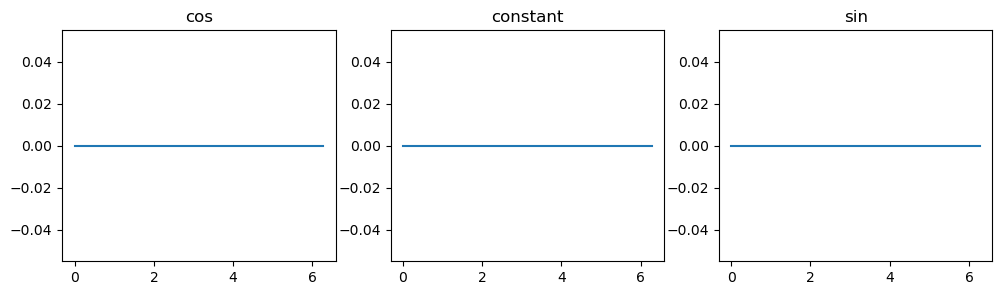

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             0.e+00         
Worst:          0.e+00          0.e+00         
Std             nan             0.e+00         
Total imaginary component
0.0

ichi
Difference


/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  A_content_padded[a_pad_row:shape[0]-a_pad_row,a_pad_col:shape[1]-a_pad_col] = A.content
/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  B_content_padded[b_pad_row:shape[0]-b_pad_row,b_pad_col:shape[1]-b_pad_col] = B.content
/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:105: RuntimeWarning: invalid value encountered in true_divide
  frac = np.abs((guess-ans)/ans)


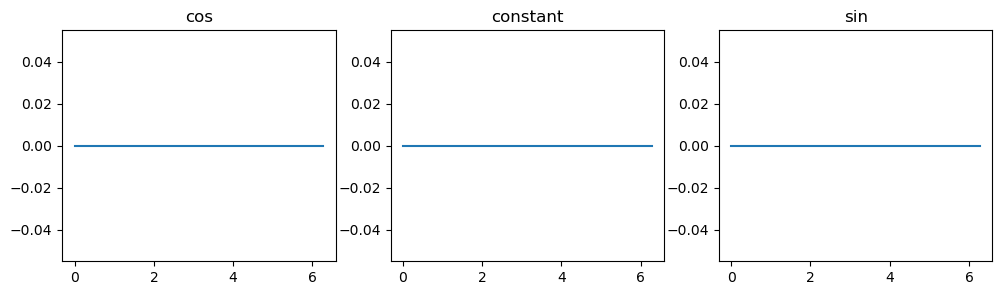

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             0.e+00         
Worst:          0.e+00          0.e+00         
Std             nan             0.e+00         
Total imaginary component
0.0



In [2]:
print('Testing dchi and ichi (even)')
rands_i = np.random.randint(1,5, size=12)


test1 = ChiPhiFuncGrid(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.zeros_like(points, dtype=np.complex128),
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
]), fourier_mode = True)

dchi_test1 = ChiPhiFuncGrid(np.array([
        -2*(np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)), 
        np.zeros_like(points, dtype=np.complex128),
        2*(np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points))
]), fourier_mode = True)

guess_dchi = diff(test1,'chi',1)
guess_ichi = int_chi(dchi_test1)
print('dchi')
compare_chiphifunc(guess_dchi, dchi_test1)
print('ichi')
compare_chiphifunc(guess_ichi, test1)

In [ ]:
print('Testing dchi and ichi (odd)')
rands_i = np.random.randint(1,5, size=12)


test1 = ChiPhiFuncGrid(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points), 
        np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points), 
        np.sin(rands_i[6]*points)+np.cos(rands_i[7]*points)
]), fourier_mode = True)

dchi_test1 = ChiPhiFuncGrid(np.array([
        -3*(np.sin(rands_i[6]*points)+np.cos(rands_i[7]*points)), 
        -(np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points)), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points), 
        3*(np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points))
]), fourier_mode = True)

guess_dchi = diff(test1,'chi',1)
guess_ichi = int_chi(dchi_test1)
print('dchi')
compare_chiphifunc(guess_dchi, dchi_test1)
print('ichi')
compare_chiphifunc(guess_ichi, test1, fourier_mode = False)

Testing dphi
Current derivative modes: fft
Current integral modes: fft
dphi based on FFT
Difference


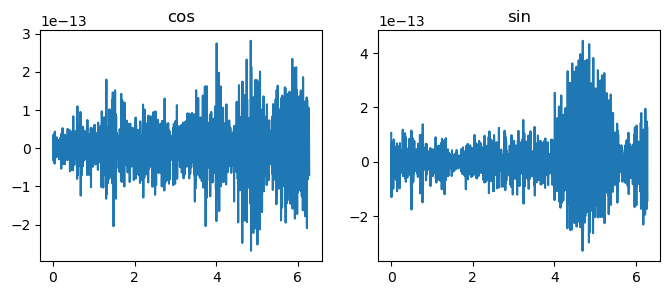

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            6.800e-01       2.821e-14      
Worst:          4.81e+02        1.407e-13      
Std             1.645e+01       2.422e-14      
Total imaginary component
0.0

dphi based on pseudo-spectral
Difference


/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  A_content_padded[a_pad_row:shape[0]-a_pad_row,a_pad_col:shape[1]-a_pad_col] = A.content
/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  B_content_padded[b_pad_row:shape[0]-b_pad_row,b_pad_col:shape[1]-b_pad_col] = B.content


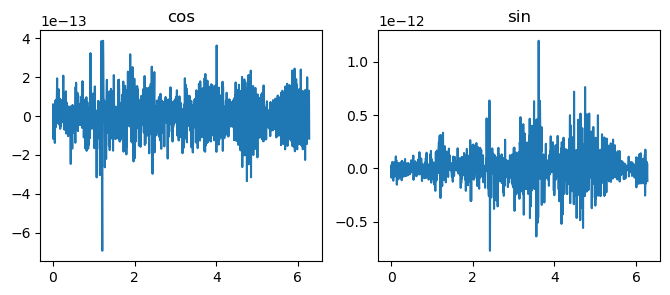

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            1.881e+00       4.031e-14      
Worst:          1.73e+03        3.465e-13      
Std             5.487e+01       3.297e-14      
Total imaginary component
0.0

spline
Difference


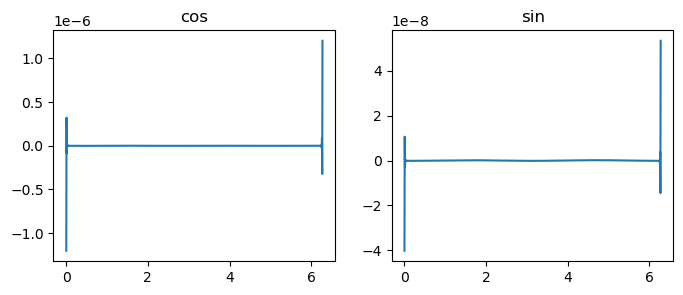

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            6.618e+03       1.865e-09      
Worst:          4.412e+06       6.011e-07      
Std             1.559e+05       2.784e-08      
Total imaginary component
0.0



In [2]:
print('Testing dphi')
chiphifunc.diff_mode = 'fft'
print('Current derivative modes:', chiphifunc.diff_mode)
print('Current integral modes:', chiphifunc.integral_mode)
rands_i = np.random.randint(1,5, size=12)
test_diff = ChiPhiFuncGrid(np.array([
        -1/rands_i[0]*np.cos(rands_i[0]*points) + 1/rands_i[1]*np.sin(rands_i[1]*points) +1/rands_i[0]*np.cos(0),
        -1/rands_i[2]*np.cos(rands_i[2]*points) + 1/rands_i[3]*np.sin(rands_i[3]*points) +1/rands_i[2]*np.cos(0)
]), fourier_mode = True)

ans = ChiPhiFuncGrid(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
]), fourier_mode = True)

guess_fft = diff(test_diff,'phi',1)
guess_pseudo_spectral = test_diff.dphi(mode = 'pseudo_spectral')
guess_spline = test_diff.dphi(mode = 'spline')
print('dphi based on FFT')
compare_chiphifunc(guess_fft, ans)
print('dphi based on pseudo-spectral')
dphi_op = dphi_op_pseudospectral(n_grid_phi)
compare_chiphifunc(guess_pseudo_spectral, ans)
print('spline')
compare_chiphifunc(guess_spline, ans)

In [3]:
print('Testing dphi on chi phi array (for testing recursion relations)')
rands_i = np.random.randint(1,5, size=12)
test_diff = ChiPhiFuncGrid(np.array([
        -1/rands_i[0]*np.cos(rands_i[0]*points) + 1/rands_i[1]*np.sin(rands_i[1]*points) +1/rands_i[0]*np.cos(0),
        -1/rands_i[2]*np.cos(rands_i[2]*points) + 1/rands_i[3]*np.sin(rands_i[3]*points) +1/rands_i[2]*np.cos(0)
]), fourier_mode = True)

ans = ChiPhiFuncGrid(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
]), fourier_mode = True)
guess = diff(test_diff,'phi',1)
guess_pseudo_spectral = test_diff.dphi(mode = 'pseudo_spectral', order = -1)
print('dphi')
print_fractional_error(evaluate_ChiPhiFunc(guess), evaluate_ChiPhiFunc(ans))

print('Testing dchi on chi phi array (for testing recursion relations)')
rands_i = np.random.randint(1,5, size=12)
a = np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points) 
b = np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
c = np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points) 
d = np.sin(rands_i[6]*points)+np.cos(rands_i[7]*points) 
e = np.sin(rands_i[8]*points)+np.cos(rands_i[9]*points)
test_diff = ChiPhiFuncGrid(np.array([a,b,c,d,e]), fourier_mode = True)
test_diff = evaluate_ChiPhiFunc(test_diff)

ans = ChiPhiFuncGrid(np.array([-4*e,-2*d,np.zeros_like(c),2*b,4*a]), fourier_mode = True)

guess = diff(test_diff,'chi',1)
print('dchi')
print_fractional_error(evaluate_ChiPhiFunc(guess), evaluate_ChiPhiFunc(ans))

Testing dphi on chi phi array (for testing recursion relations)


AttributeError: dphi order must be positive.

In [ ]:
print('Testing integrate_phi')

rands_i = np.random.randint(1,5, size=12)
test_integral = ChiPhiFuncGrid(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points), 
        np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points)
]), fourier_mode = True)

ans = ChiPhiFuncGrid(np.array([
        -1/rands_i[0]*np.cos(rands_i[0]*points) + 1/rands_i[1]*np.sin(rands_i[1]*points) +1/rands_i[0],
        -1/rands_i[2]*np.cos(rands_i[2]*points) + 1/rands_i[3]*np.sin(rands_i[3]*points) +1/rands_i[2],
        -1/rands_i[4]*np.cos(rands_i[4]*points) + 1/rands_i[5]*np.sin(rands_i[5]*points) +1/rands_i[4]
]), fourier_mode = True)


ans_2pi = ChiPhiFuncGrid(np.array([
        [-1/rands_i[0]*np.cos(rands_i[0]*2*np.pi) + 1/rands_i[1]*np.sin(rands_i[1]*2*np.pi) +1/rands_i[0]*np.cos(0)],
        [-1/rands_i[2]*np.cos(rands_i[2]*2*np.pi) + 1/rands_i[3]*np.sin(rands_i[3]*2*np.pi) +1/rands_i[2]*np.cos(0)],
        [-1/rands_i[4]*np.cos(rands_i[4]*2*np.pi) + 1/rands_i[5]*np.sin(rands_i[5]*2*np.pi) +1/rands_i[4]*np.cos(0)]
]), fourier_mode = True)
print('Testing periodic: simpson')
print_fractional_error(test_integral.integrate_phi(periodic=True, mode = 'simpson').content,ans_2pi.content)
print('Testing periodic: spline')
print_fractional_error(test_integral.integrate_phi(periodic=True, mode = 'spline').content,ans_2pi.content)

print('Testing general')
guess = test_integral.integrate_phi(periodic=False, mode='simpson')
guess_spline = test_integral.integrate_phi(periodic=False, mode='spline')
guess_fft = test_integral.integrate_phi(periodic=False, mode='fft')

print('Simpson v. ans')
compare_chiphifunc(guess, ans, fourier_mode = False)
print('Spline v. ans')
compare_chiphifunc(guess_spline, ans, fourier_mode = False)
print('FFT v. ans')
compare_chiphifunc(guess_fft, ans)


## Testing ODE solvers

In [3]:
# Creating 2 random ChiPhiFuncGrid's for testing
rands1 = np.random.randint(5, size=16)
content1 = np.array([
    rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points),
    rands1[12]/10*np.sin(rands1[13]*points) + rands1[14]/10*np.cos(rands1[15]*points)
])
test1 = ChiPhiFuncGrid(content1, fourier_mode = True)
iota = np.random.rand()# rational: np.random.randint(1,5)/np.random.randint(1,5)
# dphi + iota*dchi
dphi_test1 = ChiPhiFuncGrid(np.array([
    rands1[1]*rands1[0]/10*np.cos(rands1[1]*points) - rands1[3]*rands1[2]/10*np.sin(rands1[3]*points),
    rands1[5]*rands1[4]/10*np.cos(rands1[5]*points) - rands1[7]*rands1[6]/10*np.sin(rands1[7]*points),
    rands1[9]*rands1[8]/10*np.cos(rands1[9]*points) - rands1[11]*rands1[10]/10*np.sin(rands1[11]*points),
    rands1[13]*rands1[12]/10*np.cos(rands1[13]*points) - rands1[15]*rands1[14]/10*np.sin(rands1[15]*points)
]), fourier_mode = True)

dchi_test1 = ChiPhiFuncGrid(np.array([
    -3*(rands1[12]/10*np.sin(rands1[13]*points) + rands1[14]/10*np.cos(rands1[15]*points)),
    -(rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points)),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    3*(rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points))
]), fourier_mode = True)


Testing general integrating factor
solve_integration_factor: maximum amplitude of effective P > 17. Enabling asymptotic mode.
Batch asymptotic time(s): 0.020689010620117188
Difference


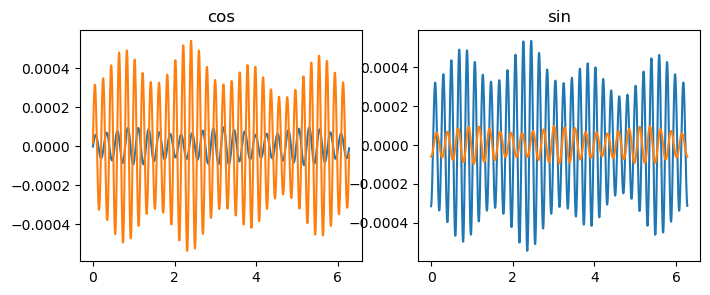

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            3.418e+08       7.388e-05      
Worst:          9.299e+11       5.412e-04      
Std             1.6e+10         1.204e-04      
Total imaginary component
0.0

Batch integration factor time(s): 0.0157470703125
Difference


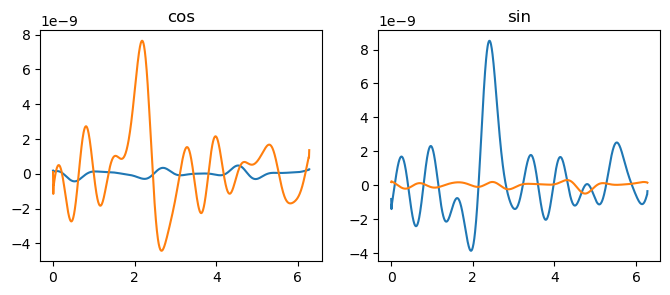

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            2.852e+03       4.929e-10      
Worst:          6.341e+06       7.876e-09      
Std             1.155e+05       1.028e-09      
Total imaginary component
0.0

solve_integration_factor: maximum amplitude of some, but not all effective P > 17. Evaluating each components individually.
solve_integration_factor: maximum amplitude of effective P > 17. Enabling asymptotic mode.
solve_integration_factor: maximum amplitude of effective P > 17. Enabling asymptotic mode.
solve_integration_factor: avg amplitude of P < 30. Approximation may not be very accurate.
Optimum truncation at order 6
individual time(s): 0.04213309288024902
Difference


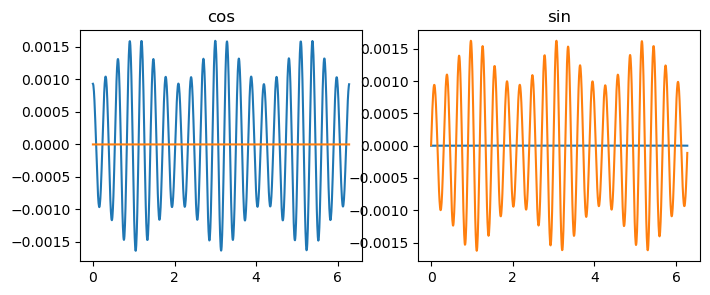

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            6.526e+09       1.998e-04      
Worst:          1.828e+13       1.636e-03      
Std             3.143e+11       4.056e-04      
Total imaginary component
0.0



In [7]:
print('Testing general integrating factor')
# By trying different amplitudes above, the theeshold of 
# instability seems to be 17.
start_time = time.time()
a = 30*np.array([5*np.e**(2j*points),
              np.e**(1j*points), 
              np.e**(3j*points), 
              np.e**(4j*points)], dtype = np.complex128)+0.5
b = 1
RHS = a*test1.content+b*dphi_test1.content
guess_batch_asymp = solve_integration_factor(a,b,RHS)
print("Batch asymptotic time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFuncGrid(guess_batch_asymp),test1)

start_time = time.time()
a = np.array([5*np.e**(2j*points),
              np.e**(1j*points), 
              np.e**(3j*points), 
              np.e**(4j*points)], dtype = np.complex128)+0.5
b = 1
RHS = a*test1.content+b*dphi_test1.content
guess_batch_int = solve_integration_factor(a,b,RHS)
print("Batch integration factor time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFuncGrid(guess_batch_int),test1)

start_time = time.time()
a = np.array([50*np.e**(2j*points),
              np.e**(1j*points), 
              20*np.e**(3j*points), 
              np.e**(4j*points)], dtype = np.complex128)+0.5
b = 1
RHS = a*test1.content+b*dphi_test1.content
guess_ind = solve_integration_factor(a,b,RHS)
print("individual time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFuncGrid(guess_ind),test1)

Testing solve_dphi_iota_dchi
Simpson mode
simpson
simpson
A


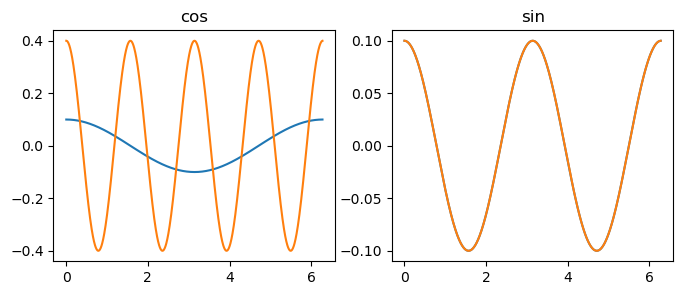

B


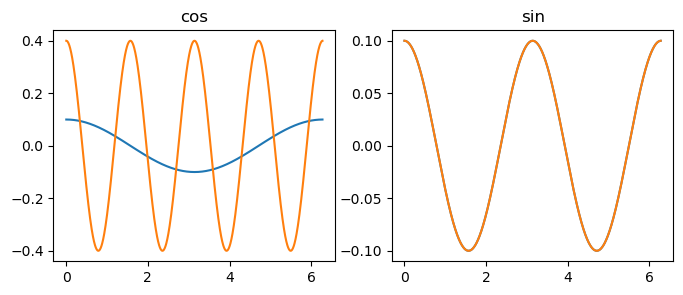

Difference


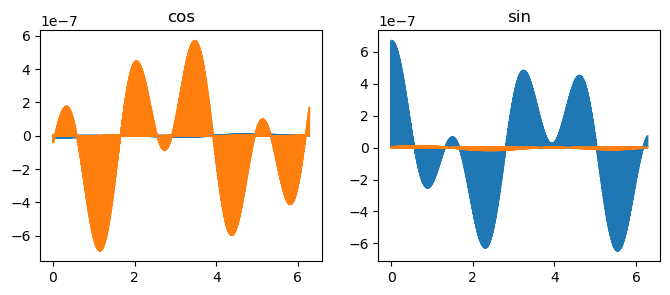

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            4.401e-03       3.565e-08      
Worst:          7.799e+00       3.452e-07      
Std             1.758e-01       7.774e-08      
Total imaginary component
0.0

Spline mode
A


/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  A_content_padded[a_pad_row:shape[0]-a_pad_row,a_pad_col:shape[1]-a_pad_col] = A.content
/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  B_content_padded[b_pad_row:shape[0]-b_pad_row,b_pad_col:shape[1]-b_pad_col] = B.content


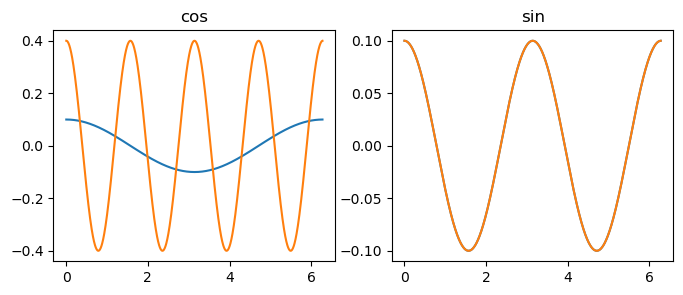

B


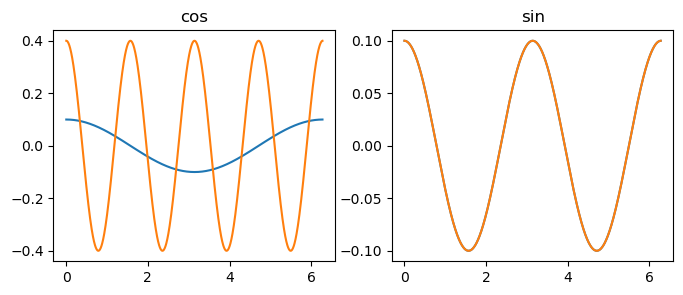

Difference


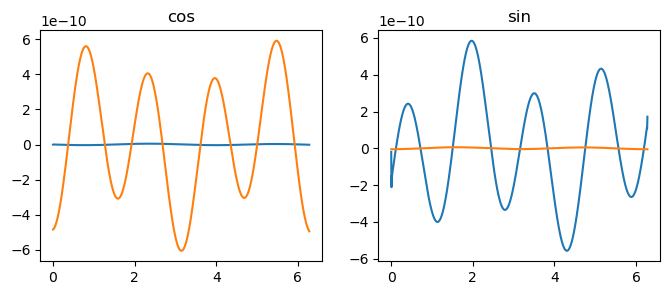

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            6.035e+01       7.478e-11      
Worst:          9.394e+04       3.035e-10      
Std             2.183e+03       9.394e-11      
Total imaginary component
0.0



In [2]:
print('Testing solve_dphi_iota_dchi')

print('Simpson mode')
test1_guess = solve_dphi_iota_dchi(iota, (dphi_test1+iota*dchi_test1).content, integral_mode = 'simpson')
compare_chiphifunc(ChiPhiFuncGrid(test1_guess),test1)


print('Spline mode')
test1_guess = solve_dphi_iota_dchi(iota, (dphi_test1+iota*dchi_test1).content)
compare_chiphifunc(ChiPhiFuncGrid(test1_guess),test1)